08/2017 

A. Gentile

### attempting to refine the parameters learnt in QMD via QLE additional running


## Library uploading

In [6]:
import SETTINGS as SETTINGS # settings for the notebook
SETTINGS.init()

..\SETTINGS.py:18: UserWarning: Using default data from > ..\..\..\Hamiltonian Learning With Seb\Decoherence_learning\NV05_HahnEcho02
  warnings.warn("Using default data from > " + str(directory))


For this run I am using data in directory: 
..\..\..\Hamiltonian Learning With Seb\Decoherence_learning\NV05_HahnEcho02


..\SETTINGS.py:67: UserWarning: Remember to set the correct parameters in the SETTINGS.PY
  warnings.warn("Remember to set the correct parameters in the SETTINGS.PY")


In [7]:
run warmup_loading_Hahn.py # import libraries

Standard libraries imported
Neg weights warning filtered
Files will be saved in:
C:\Users\ag15141\Local Documents\Cloud\Dropbox (Qsim)\QML_share_stateofart\QMD\testing_notebooks\test_results
Customised libraries imported


In [8]:
# used for log purposes
%run LoggingCode.py 

In [10]:
# print inline matplotlib figs
%matplotlib inline 

In [11]:
import HahnSimQMD as gsi # the model being used for simulations

In [12]:
run allmyfonts.py # settings for the printout

Fonts loaded


## Reload when needed

In [13]:
imp.reload(pros)
imp.reload(mpgh)
imp.reload(gsi)
imp.reload(evo)
imp.reload(distr)

<module 'Distrib' from '..\\Libraries\\QML_lib\\Distrib.py'>

# Choose model & parameters & probe states

## Data import

In [16]:
import pickle

# copy in the commas below the file to import
PIK = dire+"\\HahnEchoPeak_QMD_QLE_offlineTEST(noMOVES)_2017-08-18_18.29.48.dat"

with open(PIK, "rb") as f:
    dataold = pickle.load(f)

In [17]:
# Implement the NV centre spin- nuclear (iso)spin interaction term

spinlst = [evo.sigmax(), evo.sigmay(), evo.sigmaz()]

HFoplist = list(map(lambda j: np.kron(spinlst[j],spinlst[j]), range(len(spinlst))))
bathoplist = list(map(lambda j: np.kron(np.eye(2),spinlst[j]) , range(len(spinlst))))

oplist = []
oplist.extend(HFoplist)
oplist.extend(bathoplist)

In [18]:
print('Oplist: ' + repr(oplist))

Oplist: [array([[0, 0, 0, 1],
       [0, 0, 1, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0]]), array([[ 0.+0.j,  0.-0.j,  0.-0.j, -1.+0.j],
       [ 0.+0.j,  0.+0.j,  1.-0.j,  0.-0.j],
       [ 0.+0.j,  1.-0.j,  0.+0.j,  0.-0.j],
       [-1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j]]), array([[ 1,  0,  0,  0],
       [ 0, -1,  0,  0],
       [ 0,  0, -1,  0],
       [ 0,  0,  0,  1]]), array([[ 0.,  1.,  0.,  0.],
       [ 1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.],
       [ 0.,  0.,  1.,  0.]]), array([[ 0.+0.j,  0.-1.j,  0.+0.j,  0.-0.j],
       [ 0.+1.j,  0.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.-0.j,  0.+0.j,  0.-1.j],
       [ 0.+0.j,  0.+0.j,  0.+1.j,  0.+0.j]]), array([[ 1.,  0.,  0.,  0.],
       [ 0., -1.,  0., -0.],
       [ 0.,  0.,  1.,  0.],
       [ 0., -0.,  0., -1.]])]


In [36]:
# True params according to Felton et al. PHYSICAL REVIEW B 79, 075203 2009 for the Hyperfine tensor parameters (0:2)
# random values for the Larmour nuclei precession (3:5) -> should not affect the offline simulation

true_params = np.array([[-2.7, -2.7, -2.14, 1, 1, 1]])

In [35]:
#Probelist

probelist = [pros.Hahn_probe(oplist[0])]
print('Chosen probe: ', repr(probelist))

Chosen probe:  [array([ 0.5,  0.5,  0.5,  0.5])]


In [22]:
testFinEstimParams =  dataold[3]["2q_full"]
testFinEstimParams

array([[-2.89211754,  0.20537329],
       [-2.70041014,  0.20215423],
       [-2.01418793,  0.19947142],
       [ 1.14511489,  1.99399034],
       [ 2.3336472 ,  2.0001873 ],
       [ 3.25238663,  1.9722659 ]])

# Results from QLE trivial step-by-step implementation

In [31]:
# Prior obtained from testFinEstimParams at the end of the QMD phase

prior = distr.MultiVariateNormalDistributionNocov(len(oplist), mean = testFinEstimParams[0:len(oplist),0], sigmas = testFinEstimParams[0:len(oplist),1])

run from __"Hamiltonian Learning With Seb","Decoherence_learning","NV05_HahnEcho02"___

In [45]:
probecounter = 0
invertize=False
trotterize=False
model = gsi.HahnSimQMD(oplist=oplist, modelparams=true_params, 
                      probelist=probelist, 
                      trotter = trotterize, IQLE=invertize, datasource = 'offline')

n_particles = 400
n_experiments = 300

# higher resample_threshold -> higher frequency of resampling
# higher a in LiuWest -> less "data scrambling", slower learning
updater = qi.SMCUpdater(model, n_particles, prior, resample_thresh=0.6, resampler = qi.LiuWestResampler(a=0.8), debug_resampling=True)

#IQLE already works well with resample_thresh=0.5, resampler = qi.LiuWestResampler(a=0.8)

inv_field = [item[0] for item in model.expparams_dtype[1:] ]
print('Inversion fields are: ' + str(inv_field))
heuristic = mpgh.multiPGH(updater, oplist, inv_field=inv_field)
experiment = heuristic()
print('Heuristic output:' + repr(experiment))

expparams = np.empty((1, ), dtype=model.expparams_dtype)

print('Initialization Ready')

Inversion fields are: ['w_1', 'w_2', 'w_3', 'w_4', 'w_5', 'w_6']
Heuristic output:array([ (0.11417796529082748, -2.877542434712004, -2.7758100209916328, -1.8495986723792268, 1.1789739764539644, 3.146248131195912, 3.2657865108407305)], 
      dtype=[('t', '<f8'), ('w_1', '<f8'), ('w_2', '<f8'), ('w_3', '<f8'), ('w_4', '<f8'), ('w_5', '<f8'), ('w_6', '<f8')])
Initialization Ready


..\Libraries\QML_lib\HahnSimQMD.py:30: UserWarning: 
I am assuming the Model and System Hamiltonians to be the same
  warnings.warn("\nI am assuming the Model and System Hamiltonians to be the same", UserWarning)


datum = model.simulate_experiment(true_params, experiment)
print(repr(datum))

updater.update(datum, experiment)

In [46]:
start = time.clock()

# probecounter for the choice of the state
probecounter = 0


track_eval = np.empty([n_experiments,len(true_params[0])])
track_cov = np.empty(n_experiments)
track_time = np.empty(n_experiments)

track_particle_locs = np.empty([n_particles, len(true_params[0]), n_experiments])
track_particle_wght = np.empty([n_particles, n_experiments])


for idx_experiment in range(n_experiments):
    
    experiment = heuristic()
    #print('Chosen experiment: ' + repr(experiment))
    
    if idx_experiment == 0:
        print('Initial time selected > ' + str(experiment[0][0]))
    if idx_experiment == n_experiments-1:
        print('Final time selected > ' + str(experiment[0][0]))
    
    track_time[idx_experiment] = experiment[0][0]
    
    datum = model.simulate_experiment(true_params, experiment)
    #print('Extracted datum: ' + repr(datum))
    updater.update(datum, experiment)
#     heuristic = mpgh.multiPGH(updater, oplist, inv_field=inv_field)
    
    track_cov[idx_experiment] = np.linalg.norm(updater.est_covariance_mtx())
    
    track_particle_locs[:, :, idx_experiment] = updater.particle_locations
    track_particle_wght[:, idx_experiment] = updater.particle_weights

    new_eval = updater.est_mean()
    track_eval[idx_experiment] = new_eval
    
end = time.clock()

print("\n\nElapsed time:" + str(end-start) + " secs")

Initial time selected > 0.152198809282


qinfer.smc - DEBUG - Resampling changed mean by [-0.00197786 -0.01491213 -0.00634698  0.02108602 -0.0638141   0.0125693 ]. Norm change in cov: 0.3874064586943918.
qinfer.smc - DEBUG - Resampling changed mean by [-0.00748286 -0.00641746  0.01007585  0.00174842 -0.0623581  -0.01954165]. Norm change in cov: 0.27093948305288906.
qinfer.smc - DEBUG - Resampling changed mean by [ 0.00455539 -0.02677673  0.01770008 -0.00772039  0.03449741 -0.09101725]. Norm change in cov: 0.14958594076960974.
qinfer.smc - DEBUG - Resampling changed mean by [-0.01967317  0.00371265  0.00652138 -0.11272516 -0.03136291  0.00944174]. Norm change in cov: 0.14233903841145748.
qinfer.smc - DEBUG - Resampling changed mean by [-0.00592615  0.00790423 -0.00394563  0.01835618 -0.04832727 -0.03230281]. Norm change in cov: 0.18842281624204463.
qinfer.smc - DEBUG - Resampling changed mean by [ 0.00766658 -0.01200224 -0.0058574  -0.07004285  0.10361238 -0.0481715 ]. Norm change in cov: 0.18476412650204108.
qinfer.smc - DEBU

Final time selected > 0.998532401692


Elapsed time:294.7694775335244 secs


## Data export and plotting

In [48]:
labelize = '_IQLE' if invertize == True else '_QLE'

In [86]:
thisfile = "_alldata___"
thisfile = dire+"\\QLEafterQMD_Hahn2qubits(HT)_Nparts_"+str(n_particles)+thisfile+mytimestamp()+".dat"
print('Data saving in\n'+thisfile)

data = [track_eval, track_cov, track_time, track_particle_locs, track_particle_wght]

with open(thisfile, "wb") as f:
    pickle.dump(data, f)

Data saving in
C:\Users\ag15141\Local Documents\Cloud\Dropbox (Qsim)\QML_share_stateofart\QMD\testing_notebooks\test_results\QLEafterQMD_Hahn2qubits(HT)_Nparts_400_alldata____2017-08-23_13.57.50.dat


In [87]:
# Reload if OLDDATA are required
PIK = dire+"\\QLEafterQMD_Hahn2qubits(HT)_Nparts_400_alldata____2017-08-23_13.57.50.dat"

with open(PIK, "rb") as f:
    dataold = pickle.load(f)
    
#prepare data
track_eval = dataold[0]
track_cov =  dataold[1]
track_time =  dataold[2]
track_particle_locs =  dataold[3]
track_particle_wght =  dataold[4]

C:\Users\ag15141\Local Documents\Cloud\Dropbox (Qsim)\QML_share_stateofart\QMD\testing_notebooks\test_results\QLEafterQMD_Hahn2qubits(HT)_Nparts_400_tracktime____2017-08-23_13.12.42.pdf


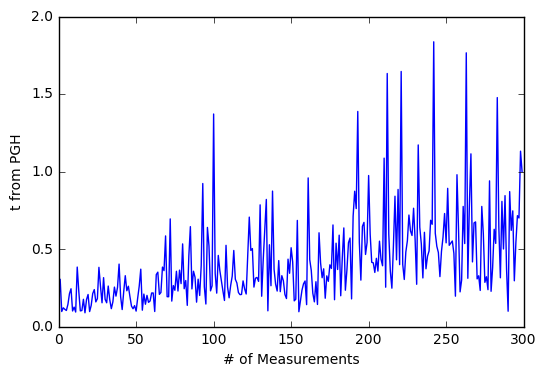

In [80]:
plt.plot(track_time)
plt.xlabel('# of Measurements')
plt.ylabel('t from PGH')

thisfig = "_tracktime___"
filefigname = dire+"\\QLEafterQMD_Hahn2qubits(HT)_Nparts_"+str(n_particles)+thisfig+mytimestamp()+".pdf"
filefigname = os.path.normpath(filefigname)
print(filefigname)
plt.savefig(filefigname)

plt.show()

C:\Users\ag15141\Local Documents\Cloud\Dropbox (Qsim)\QML_share_stateofart\QMD\testing_notebooks\test_results\QLEafterQMD_Hahn2qubits(HT)_Nparts_400_trackcov____2017-08-23_13.12.42.pdf


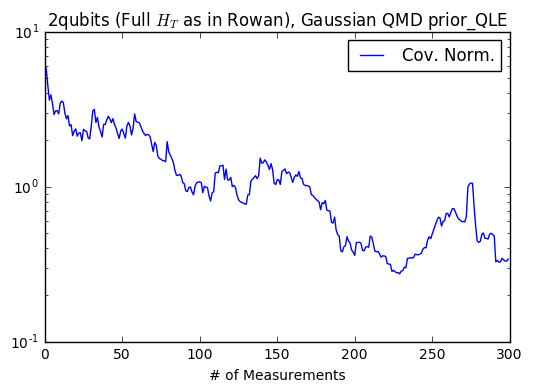

In [83]:
#plt.semilogy(track_loss, label='Q.L.')
plt.semilogy(track_cov, label='Cov. Norm.')
plt.legend()
plt.xlabel('# of Measurements')
plt.title(r"2qubits (Full $H_{T}$ as in Rowan), Gaussian QMD prior"+ labelize)


thisfig = "_trackcov___"
filefigname = dire+"\\QLEafterQMD_Hahn2qubits(HT)_Nparts_"+str(n_particles)+thisfig+mytimestamp()+".pdf"
filefigname = os.path.normpath(filefigname)
print(filefigname)
plt.savefig(filefigname)


plt.show()

C:\Users\ag15141\Local Documents\Cloud\Dropbox (Qsim)\QML_share_stateofart\QMD\testing_notebooks\test_results\QLEafterQMD_Hahn2qubits(HT)_Nparts_400_trackparams____2017-08-23_13.12.42.pdf


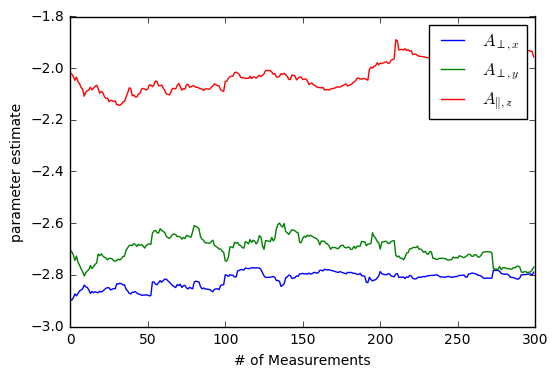

In [84]:
plt.plot(track_eval[:,0], label='$A_{\perp, x}$')
plt.plot(track_eval[:,1], label='$A_{\perp, y}$')
plt.plot(track_eval[:,2], label='$A_{\|, z}$')

plt.xlabel('# of Measurements')
plt.ylabel('parameter estimate')
plt.legend()

thisfig = "_trackparams___"
filefigname = dire+"\\QLEafterQMD_Hahn2qubits(HT)_Nparts_"+str(n_particles)+thisfig+mytimestamp()+".pdf"
filefigname = os.path.normpath(filefigname)
print(filefigname)
plt.savefig(filefigname)

plt.show()

# Multiple tests

In [300]:
import pickle

# copy in the commas below the file to import
PIK = dire+"\\HahnEchoPeak_QMD_QLE_offlineTEST(noMOVES)_2017-08-18_18.29.48.dat"

with open(PIK, "rb") as f:
    dataold = pickle.load(f)
    
testFinEstimParams =  dataold[3]["2q_full"]

In [301]:
myHfA = testFinEstimParams[range(3),0]
myBathfreq = testFinEstimParams[range(3),1]
newmean = np.append(myHfA,myBathfreq)

In [307]:
newsigmas = testFinEstimParams[0:len(oplist),1]
newsigmas = np.repeat(0.3, 6)

In [308]:
# Prior obtained from testFinEstimParams at the end of the QMD phase

prior = distr.MultiVariateNormalDistributionNocov(len(oplist), mean = newmean, sigmas = newsigmas)

run from __"Hamiltonian Learning With Seb","Decoherence_learning","NV05_HahnEcho02"___

In [309]:
probecounter = 0
invertize=False
trotterize=False
model = gsi.HahnSimQMD(oplist=oplist, modelparams=true_params, 
                      probelist=probelist, 
                      trotter = trotterize, IQLE=invertize, datasource = 'offline')

n_particles = 1000
n_experiments = 300

# higher resample_threshold -> higher frequency of resampling
# higher a in LiuWest -> less "data scrambling", slower learning
updater = qi.SMCUpdater(model, n_particles, prior, resample_thresh=0.6, resampler = qi.LiuWestResampler(a=0.8), debug_resampling=False)

#IQLE already works well with resample_thresh=0.5, resampler = qi.LiuWestResampler(a=0.8)

inv_field = [item[0] for item in model.expparams_dtype[1:] ]
print('Inversion fields are: ' + str(inv_field))
heuristic = mpgh.multiPGH(updater, oplist, inv_field=inv_field)
experiment = heuristic()
experiment[0][0] = 0.3*experiment[0][0]
print('Heuristic output:' + repr(experiment))

expparams = np.empty((1, ), dtype=model.expparams_dtype)

print('Initialization Ready')

Inversion fields are: ['w_1', 'w_2', 'w_3', 'w_4', 'w_5', 'w_6']
Heuristic output:array([ (0.11502380545872315, -2.8508684404098945, -3.2864375579022345, -1.8571834927393707, 0.7594648451508683, 0.05824636780634598, -0.1453097746477954)], 
      dtype=[('t', '<f8'), ('w_1', '<f8'), ('w_2', '<f8'), ('w_3', '<f8'), ('w_4', '<f8'), ('w_5', '<f8'), ('w_6', '<f8')])
Initialization Ready


..\Libraries\QML_lib\HahnSimQMD.py:30: UserWarning: 
I am assuming the Model and System Hamiltonians to be the same
  warnings.warn("\nI am assuming the Model and System Hamiltonians to be the same", UserWarning)


datum = model.simulate_experiment(true_params, experiment)
print(repr(datum))

updater.update(datum, experiment)

In [ ]:
n_trials = 100

start = time.clock()

# probecounter for the choice of the state
probecounter = 0

track_eval = np.empty([n_trials,n_experiments,len(true_params[0])])
track_stdev = np.empty([n_trials,n_experiments,len(true_params[0])])
track_cov = np.empty([n_trials,n_experiments])
track_time = np.empty([n_trials,n_experiments])

for trial in range(n_trials):
    updater = qi.SMCUpdater(model, n_particles, prior, resample_thresh=0.6, resampler = qi.LiuWestResampler(a=0.8), debug_resampling=False)

    heuristic = mpgh.multiPGH(updater, oplist, inv_field=inv_field)

    for idx_experiment in range(n_experiments):

        experiment = heuristic()
        experiment[0][0] = 0.3*experiment[0][0]
        track_time[trial, idx_experiment] = experiment[0][0]

        datum = model.simulate_experiment(true_params, experiment)
        updater.update(datum, experiment)
    #     heuristic = mpgh.multiPGH(updater, oplist, inv_field=inv_field)

        track_cov[trial,idx_experiment] = np.linalg.norm(updater.est_covariance_mtx())
        track_stdev[trial,idx_experiment] = np.diag(updater.est_covariance_mtx())

        new_eval = updater.est_mean()
        track_eval[trial,idx_experiment] = new_eval
    
    print("Done iteration " + str(trial))
    
end = time.clock()

print("\n\nElapsed time:" + str(end-start) + " secs")

## Data export - multiple tests

In [318]:
allfilenames = dire+"\\QLEafterQMD_Hahn2qubits(HT)_Nruns_"+str(10*n_trials)+"_Nparts_"+str(n_particles)

In [319]:
labelize = '_IQLE' if invertize == True else '_QLE'

In [401]:
#timestamp = mytimestamp()

thisfile = "_alldata___"
thisfile = allfilenames+thisfile+timestamp+".dat"
print('Data saving in\n'+thisfile)

data = [track_eval, track_cov, track_stdev, track_time, track_particle_locs, track_particle_wght]

with open(thisfile, "wb") as f:
    pickle.dump(data, f)

Data saving in
C:\Users\ag15141\Local Documents\Cloud\Dropbox (Qsim)\QML_share_stateofart\QMD\testing_notebooks\test_results\QLEafterQMD_Hahn2qubits(HT)_Nruns_100_Nparts_1000_alldata____2017-08-23_13.12.42.dat


In [471]:
# Reload if OLDDATA are required
PIK = dire+"\\QLEafterQMD_Hahn2qubits(HT)_Nruns_100_Nparts_1000_alldata____2017-08-23_13.12.42.dat"

with open(PIK, "rb") as f:
    dataold = pickle.load(f)
    
#prepare data
track_eval = dataold[0]
track_cov =  dataold[1]
track_stdev =  dataold[2]
track_time =  dataold[3]
track_particle_locs =  dataold[4]
track_particle_wght =  dataold[5]

## Plots - multiple tests

C:\Users\ag15141\Local Documents\Cloud\Dropbox (Qsim)\QML_share_stateofart\QMD\testing_notebooks\test_results\QLEafterQMD_Hahn2qubits(HT)_Nruns_100_Nparts_1000_tracktime____2017-08-23_13.12.42.pdf


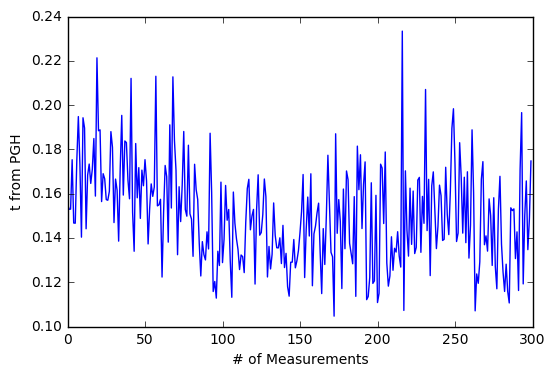

In [321]:
meantime = np.mean(track_time, axis = 0)

plt.plot(meantime)
plt.xlabel('# of Measurements')
plt.ylabel('t from PGH')

thisfig = "_tracktime___"
filefigname = allfilenames+thisfig+timestamp+".pdf"
filefigname = os.path.normpath(filefigname)
print(filefigname)
#plt.savefig(filefigname)

plt.show()

C:\Users\ag15141\Local Documents\Cloud\Dropbox (Qsim)\QML_share_stateofart\QMD\testing_notebooks\test_results\QLEafterQMD_Hahn2qubits(HT)_Nruns_100_Nparts_1000_trackcov____2017-08-23_13.12.42.pdf


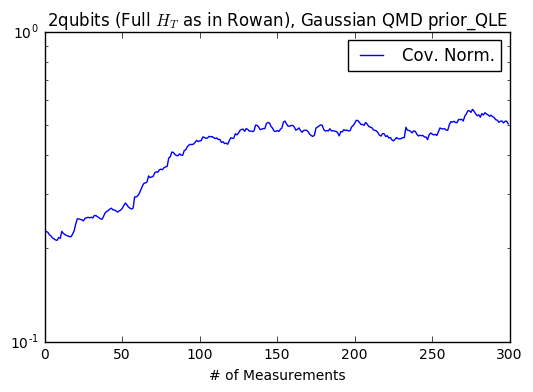

In [322]:
meancov = np.mean(track_cov, axis = 0)
#meancov = track_cov[2]

plt.semilogy(meancov, label='Cov. Norm.')
plt.legend()
plt.xlabel('# of Measurements')
plt.title(r"2qubits (Full $H_{T}$ as in Rowan), Gaussian QMD prior"+ labelize)


thisfig = "_trackcov___"
filefigname = allfilenames+thisfig+timestamp+".pdf"
filefigname = os.path.normpath(filefigname)
print(filefigname)
#plt.savefig(filefigname)

plt.show()

C:\Users\ag15141\Local Documents\Cloud\Dropbox (Qsim)\QML_share_stateofart\QMD\testing_notebooks\test_results\QLEafterQMD_Hahn2qubits(HT)_Nruns_100_Nparts_1000_trackparams____2017-08-23_13.12.42.pdf


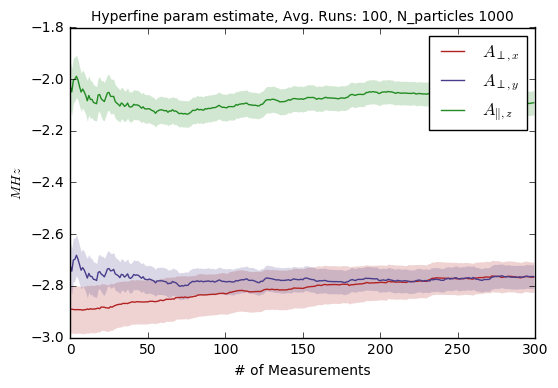

In [399]:
steps = range(len(meaneval[:,0]))

meaneval = np.mean(track_eval, axis = 0)
#meaneval = track_eval[2]
meanstdev = np.mean(track_stdev, axis = 0)


plt.plot(meaneval[:,0], 'k', label='$A_{\perp, x}$', color='firebrick')
plt.fill_between(steps, meaneval[:,0]-meanstdev[:,0], meaneval[:,0]+meanstdev[:,0],
    alpha=0.2, linewidth=0, facecolor='firebrick', antialiased=True)

plt.plot(meaneval[:,1], label='$A_{\perp, y}$', color='darkslateblue')
plt.fill_between(steps, meaneval[:,1]-meanstdev[:,1], meaneval[:,1]+meanstdev[:,1],
    alpha=0.2, linewidth=0, facecolor='darkslateblue', antialiased=True)

plt.plot(meaneval[:,2], label='$A_{\|, z}$', color='forestgreen')
plt.fill_between(steps, meaneval[:,2]-meanstdev[:,2], meaneval[:,2]+meanstdev[:,2],
    alpha=0.2, linewidth=0, facecolor='forestgreen', antialiased=True)

plt.title("Hyperfine param estimate, Avg. Runs: "+str(10*n_trials) + ", N_particles " + str(n_particles), fontsize =10)
plt.xlabel('# of Measurements')
plt.ylabel('$MHz$')
plt.legend()

thisfig = "_trackparams___"
filefigname = allfilenames+thisfig+timestamp+".pdf"
filefigname = os.path.normpath(filefigname)

#UNCOMMENT TO SAVE PICTURE
print(filefigname)
plt.savefig(filefigname)

plt.show()

# Compare the average obtained parameters against the experimental dynamics

In [435]:
# Extract experimental data to plot

directory = os.path.join("..","..","..","Hamiltonian Learning With Seb","Decoherence_learning","NV05_HahnEcho02")
moredata =  ImportAllFolder_Hahnpeak(directory, clean_duplicates = True)  

myrange = range(0, min(moredata.shape[0],500)) 

# the 1000 factor converts ns to us
moredata = [ [moredata[i,0]/1000 , moredata[i,1]] for i in myrange]
moredata = np.array(moredata)

offset = 0.18
moredata[:,0] = moredata[:,0]-offset

expdata = rescaledatatofullrange(moredata[:,1])

In [436]:
# Select a specific run of the simulations if needed
runID = 5

In [493]:
testFinEstimParams

array([-2.85253252, -2.76159646, -2.12561744,  0.65648023,  0.43504202,
        0.54913253])

Estimate the goodness of fit via **R**$^2$

In [531]:
datarange = 185 #select the data range for which the run has been performed

datamean = np.mean(expdata[0:datarange])
print("Average of data: " + str(datamean))
datavar = np.sum( (expdata[0:datarange] -datamean)**2  )
print("Variance of data: " + str(datavar))

Average of data: 0.567832450103
Variance of data: 12.7963915588


In [536]:
#Extract average (singular) values out of the simulations

myrange = len(track_eval[0])
Resid = np.empty(myrange)

start = time.clock()
EstimParams = np.mean(track_eval, axis = 0)
#EstimParams = track_eval[runID][-1]
for i in range(myrange):
    myHfA = EstimParams[i][0:3]
    myBathfreq =  EstimParams[60][3:6]
    simdata = HTM.Q2_HF_Precession(moredata[0:datarange,0], HfA = myHfA, Bathfreq = myBathfreq)
#     simdata = HTM.Q2_HF_Precession_deco(moredata[0:datarange,0], HfA = myHfA, Bathfreq = myBathfreq, decoTau_c = 5.43)
    Resid[i] = np.sum( (simdata - expdata[0:datarange])**2  )
print("Time elapsed: " + str(time.clock()-start))

Time elapsed: 79.6947657346027


C:\Users\ag15141\Local Documents\Cloud\Dropbox (Qsim)\QML_share_stateofart\QMD\testing_notebooks\test_results\QLEafterQMD_Hahn2qubits(HT)_Nruns_100_Nparts_1000_trackRsq____2017-08-23_13.12.42.pdf


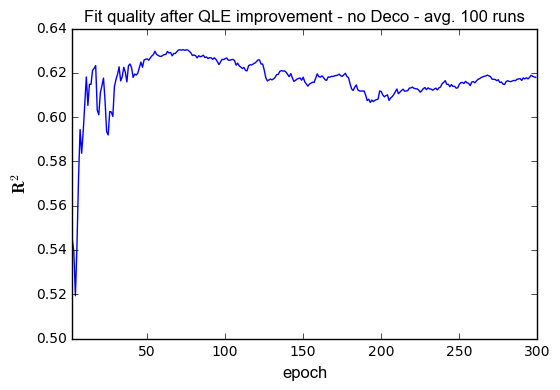

In [561]:
plt.plot(1-Resid/datavar, "b-")

plt.title(r'Fit quality after QLE improvement - no Deco - avg. 100 runs', **title_font)

plt.xlabel(r'epoch', **axis_font)
plt.ylabel(r'$\mathbf{R}^2$', **axis_font)

plt.xlim([2,300])

thisfig = "_trackRsq___"
filefigname = allfilenames+thisfig+timestamp+".pdf"
filefigname = os.path.normpath(filefigname)

#UNCOMMENT TO SAVE PICTURE
print(filefigname)
plt.savefig(filefigname)

plt.show()

Report the plot of the final average result of the fit

In [464]:
#Extract average (singular) values out of the simulations

testFinEstimParams = np.mean(track_eval[:][-1], axis=0)
#testFinEstimParams = track_eval[runID][-1]
myHfA = testFinEstimParams[0:3]
print(myHfA)
myBathfreq = testFinEstimParams[3:6]
print(myBathfreq)

[-2.85253252 -2.76159646 -2.12561744]
[ 0.65648023  0.43504202  0.54913253]


myHfA = [-2.89211754, -2.70041014, -2.01418793]
myBathfreq = [ 1,2,3]

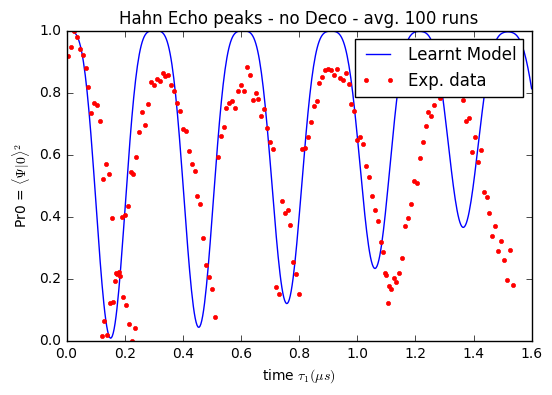

In [564]:
tvec = np.linspace(0.,1.6,500)

# myHfA = np.array([-2.63100105, -2.73375192,  -2.44147498])
# myBathfreq = np.array([0.20774799,0.20085928,0.19418206])

simdata = HTM.Q2_HF_Precession(tvec, HfA = myHfA, Bathfreq = myBathfreq)
plt.plot(tvec, simdata, "b-")

plt.plot(moredata[:,0], expdata, "r.")
plt.xlim([0,1.6])

plt.legend(('Learnt Model', 'Exp. data'))

plt.title(r'Hahn Echo peaks - no Deco - avg. 100 runs')
plt.xlabel(r'time $\tau_1 (\mu s)$')
plt.ylabel(r'Pr0 = $\langle \Psi | 0 \rangle ^2 $')

filefigname = dire+"\CompareData_PostProcModel_noDeco"+timestamp+".pdf"
filefigname = os.path.normpath(filefigname)
# plt.savefig(filefigname)
# print('Picture saved in\n'+filefigname)

plt.show()